In [ ]:
"""
Investigating what a first pass would 
look like where we 

1) Run meshparty skeletonization
2) Divide the skeleton into segments
3) Compute the sdf width of eah of the branches
4) View the widths of each of the branch
5) Filter away the small width branches

"""

In [ ]:
"""
How to do the meshparty skeletonization:

limb_obj_tr_io  = trimesh_io.Mesh(vertices = limb_mesh_mparty.vertices,
                                                       faces = limb_mesh_mparty.faces,
                                                       normals=limb_mesh_mparty.face_normals)
                                                       
meshparty_time = time.time()
                print("\nStep 1: Starting Skeletonization")
                sk_meshparty_obj, v = m_sk.skeletonize_mesh(limb_obj_tr_io,
                                      soma_pt = root,
                                      soma_radius = 0,
                                      collapse_soma = False,
                                      invalidation_d=12000,
                                      smooth_vertices=True,
                                       smooth_neighborhood = 1,
                                      compute_radius = True, #Need the pyembree list
                                      compute_original_index=True,
                                      verbose=True)
                print(f"Total time for meshParty skeletonization = {time.time() - meshparty_time}")

sk_meshparty = sk_meshparty_obj.vertices[sk_meshparty_obj.edges]
                total_skeletons.append(sk_meshparty)






"""

In [1]:
from os import sys
sys.path.append("/meshAfterParty/")

In [21]:
import trimesh_utils as tu
import meshparty_skeletonize as m_sk
import neuron_utils as nru
from meshparty import trimesh_io
import time

# Import a test neuron

In [5]:
neur_file = "/notebooks/test_neurons/Segmentation_2/meshparty/864691135548568516_single_soma_inhib_axon_cloud"
cloud_neuron = nru.decompress_neuron(filepath=neur_file,
                      original_mesh=neur_file)

Decompressing Neuron in minimal output mode...please wait


# Getting the limb and a starting node to try

In [84]:
import neuron_visualizations as nviz

In [85]:
nviz.visualize_neuron(cloud_neuron,
                     visualize_type=["mesh"],
                     limb_branch_dict=dict(L0="all"),
                     mesh_resolution="limb")


 Working on visualization type: mesh


In [ ]:
limb_object = cloud_neuron[0]
root = np.array(limb_object.current_touching_soma_vertices[0])

# Trying the meshparty skeletonization (with functions)

In [166]:
m_sk = reload(m_sk)
sk_meshparty_obj,limb_mesh_mparty = m_sk.skeletonize_mesh_largest_component(limb_object.mesh,
                                                        root=np.array(limb_object.current_touching_soma_vertices[0]))
m_sk = reload(m_sk)

(segment_branches, #skeleton branches
divided_submeshes, divided_submeshes_idx, #mesh correspondence (mesh and indices)
segment_widths_median) = m_sk.skeleton_obj_to_branches(sk_meshparty_obj,
                                                      mesh = limb_mesh_mparty)


smooth_neighborhood = 1


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [01:37<00:00, 97.49s/it]

# mesh skeletonization without functions

In [120]:

limb_mesh_mparty = limb_object.mesh

# just getting the largest connected component
connect_comp = list(nx.connected_components(nx.from_edgelist(limb_mesh_mparty.face_adjacency)))
max_connect_comp = np.argmax([len(k) for k in connect_comp])
limb_mesh_mparty = limb_mesh_mparty.submesh([list(connect_comp[max_connect_comp])],append=True)


m_sk = reload(m_sk)
limb_obj_tr_io  = trimesh_io.Mesh(vertices = limb_mesh_mparty.vertices,
                                                       faces = limb_mesh_mparty.faces,
                                                       normals=limb_mesh_mparty.face_normals)
                                                       
meshparty_time = time.time()
print("\nStep 1: Starting Skeletonization")
sk_meshparty_obj, v = m_sk.skeletonize_mesh(limb_obj_tr_io,
                      soma_pt = root,
                      soma_radius = 0,
                      collapse_soma = False,
                      invalidation_d=12000,
                      smooth_vertices=True,
                       smooth_neighborhood = 1,
                      compute_radius = True, #Need the pyembree list
                      compute_original_index=True,
                      verbose=True)
print(f"Total time for meshParty skeletonization = {time.time() - meshparty_time}")

sk_meshparty = sk_meshparty_obj.vertices[sk_meshparty_obj.edges]




Step 1: Starting Skeletonization
smooth_neighborhood = 1
smooth_neighborhood = 1


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [01:38<00:00, 98.67s/it]

skel_verts.shape = (60435, 3)
orig_skel_index.shape = (60435,)
After smooth verts skel_verts.shape = (60435, 3)
new_v.shape = (60435, 3)
vert_filter.shape = (60435,)
orig_skel_index[vert_filter].shape = (60435,)
Total time for meshParty skeletonization = 102.72767996788025


# This will divide skeleton into branches with their widths

In [121]:
import time
import skeleton_utils as sk
import general_utils as gu
import numpy as np
import compartment_utils as cu
import itertools
import trimesh_utils as tu


meshparty_n_surface_downsampling = 0
meshparty_segment_size = 1000

In [122]:
cu = reload(cu)

#Step 2: Getting the branches
print("\nStep 2: Decomposing Branches")
meshparty_time = time.time()

segments, segment_maps = m_sk.compute_segments(sk_meshparty_obj)
# getting the skeletons that go with them
segment_branches = [sk_meshparty_obj.vertices[np.vstack([k[:-1],k[1:]]).T] for k in segments]


#------------ Add in the downsampling and resizing ----------------- #


if meshparty_n_surface_downsampling > 0:
    print(f"Going to downsample the meshparty segments {meshparty_n_surface_downsampling}")
    for j,s in enumerate(segment_branches):
        for i in range(n_surface_downsampling):
            s = sk.downsample_skeleton(s)
        segment_branches[j] = s

if meshparty_segment_size > 0:
    print(f"Resizing meshparty skeletal segments to length {meshparty_segment_size} nm")
    for j,s in enumerate(segment_branches):
        segment_branches[j] = sk.resize_skeleton_branch(s,segment_width = meshparty_segment_size)

#------------ END OF downsampling and resizing ----------------- #


print(f"Total time for meshParty decomposition = {time.time() - meshparty_time}")


# -- Step 3: Creating the mesh correspondence --
print("\nStep 3: Mesh correspondence")
meshparty_time = time.time()

sk_vertices_to_mesh_vertices = gu.invert_mapping(sk_meshparty_obj.mesh_to_skel_map)
#getting a list of all the original vertices that belong to each segment
segment_mesh_vertices = [np.unique(np.concatenate([sk_vertices_to_mesh_vertices[k] for k in segment_list])) for segment_list in segments]
#getting a list of all the original vertices that belong to each segment
segment_mesh_faces = [np.unique(limb_mesh_mparty.vertex_faces[k]) for k in segment_mesh_vertices]
segment_mesh_faces = [k[k>=0] for k in segment_mesh_faces]

face_lookup = gu.invert_mapping(segment_mesh_faces)

curr_limb_mesh = limb_mesh_mparty


original_labels = set(list(itertools.chain.from_iterable(list(face_lookup.values()))))
print(f"max(original_labels),len(original_labels) = {(max(original_labels),len(original_labels))}")

face_coloring_copy = cu.resolve_empty_conflicting_face_labels(curr_limb_mesh = curr_limb_mesh,
                                                            face_lookup=face_lookup,
                                                            no_missing_labels = list(original_labels))


# -- splitting the mesh pieces into individual pieces
divided_submeshes,divided_submeshes_idx = tu.split_mesh_into_face_groups(curr_limb_mesh,face_coloring_copy)

#print(f"divided_submeshes = {divided_submeshes}")
#print(f"divided_submeshes_idx = {divided_submeshes_idx}")

print(f"Total time for meshParty mesh correspondence = {time.time() - meshparty_time}")

# -- Step 4: Getting the Widths ---
print("\nStep 4: Retrieving Widths")
meshparty_time = time.time()

segment_width_measurements = [sk_meshparty_obj.vertex_properties["rs"][k] for k in segments]
segment_widths_median = [np.median(k) for k in segment_width_measurements]

print(f"Total time for meshParty Retrieving Widths = {time.time() - meshparty_time}")
# ---- Our Final Products -----

segment_branches #skeleton branches

divided_submeshes, divided_submeshes_idx #mesh correspondence (mesh and indices)

segment_widths_median #widths


Step 2: Decomposing Branches
Resizing meshparty skeletal segments to length 1000 nm
Total time for meshParty decomposition = 4.958583831787109

Step 3: Mesh correspondence
max(original_labels),len(original_labels) = (450, 451)
empty_indices % = 0.0
 conflict_indices % = 0.011054777987360145



AFTER face_lookup_resolved_test



Total time for meshParty mesh correspondence = 18.384977102279663

Step 4: Retrieving Widths
Total time for meshParty Retrieving Widths = 0.02563929557800293


[202.30618962669325,
 224.53923710827723,
 370.62192800487327,
 331.2627963033257,
 375.9887013396662,
 361.7156149913423,
 394.332449592627,
 249.2564443199248,
 211.04525835124343,
 423.43148109884305,
 498.00580997041203,
 612.5528761976142,
 615.7591205166335,
 164.43405407323073,
 205.2232182016515,
 215.23774313770392,
 275.3582648305637,
 282.87707880132916,
 316.1467262435874,
 120.4141297987003,
 169.16061399215715,
 163.7386316720029,
 154.07202375112126,
 215.85606526911113,
 299.63294724687944,
 314.7820798397001,
 315.02114908661804,
 129.74875180085823,
 224.32605533507825,
 142.57606149046683,
 182.93859732134644,
 242.24555810573338,
 258.4089079711605,
 247.6662388877639,
 160.85244461392455,
 203.37532882455469,
 180.38885404654707,
 234.69840374487464,
 218.55825751754116,
 266.47069165994014,
 240.67044755906738,
 362.2293758268546,
 355.12903174955363,
 289.0908871948698,
 340.85001010872503,
 343.9444645288126,
 469.8425109907831,
 586.8076965341804,
 241.30579987

In [124]:
segment_widths_median = np.array(segment_widths_median)

(array([130., 158.,  87.,  37.,  16.,   9.,   5.,   6.,   2.,   1.]),
 array([ 93.61162778, 157.05902526, 220.50642274, 283.95382022,
        347.4012177 , 410.84861518, 474.29601266, 537.74341014,
        601.19080762, 664.63820511, 728.08560259]),
 <BarContainer object of 10 artists>)

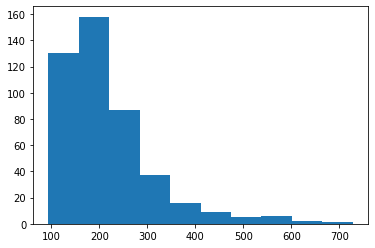

In [123]:
import matplotlib.pyplot as plt
plt.hist(segment_widths_median)

In [129]:
segment_branches

[array([[[584348.3973009 , 747793.00873243, 917563.28145292],
         [583973.88933941, 747715.29661503, 916640.56823988]],
 
        [[583973.88933941, 747715.29661503, 916640.56823988],
         [583446.84970347, 747791.74546544, 915800.59219111]],
 
        [[583446.84970347, 747791.74546544, 915800.59219111],
         [582924.63716936, 748026.85769205, 914981.64962195]],
 
        [[582924.63716936, 748026.85769205, 914981.64962195],
         [582523.44111705, 748145.24660157, 914075.31463323]],
 
        [[582523.44111705, 748145.24660157, 914075.31463323],
         [582230.34340953, 748335.58681704, 913140.12178413]],
 
        [[582230.34340953, 748335.58681704, 913140.12178413],
         [581784.70499   , 748730.24270273, 912344.66536907]],
 
        [[581784.70499   , 748730.24270273, 912344.66536907],
         [581177.58375504, 749133.14805996, 911663.41857784]],
 
        [[581177.58375504, 749133.14805996, 911663.41857784],
         [580743.20825874, 749308.97645451, 91079

In [169]:
#using the width threshold
width_threshold = 600
size_threshold = 200
segment_widths_median = np.array(segment_widths_median)
pieces_above_width_thr = segment_widths_median>width_threshold
#pieces_above_size_thr = np.array([len(k.faces) > size_threshold for k in divided_submeshes.values()])

pieces_above_threshold = np.where(pieces_above_width_thr)[0]# & pieces_above_size_thr)[0]

sk_large = [segment_branches[k] for k in pieces_above_threshold]
mesh_large = [divided_submeshes[k] for k in pieces_above_threshold]

nviz.plot_objects(main_mesh=tu.combine_meshes([limb_mesh_mparty,cloud_neuron["S0"].mesh]),
                  main_mesh_color="green",
    skeletons=sk_large,
                 meshes=mesh_large,
                  meshes_colors="red")

# Ohter possible metrics

(array([ 59., 100.,  86.,  85.,  58.,  30.,  17.,  11.,   3.,   2.]),
 array([129.88266712, 206.02516974, 282.16767236, 358.31017498,
        434.45267759, 510.59518021, 586.73768283, 662.88018545,
        739.02268807, 815.16519068, 891.3076933 ]),
 <BarContainer object of 10 artists>)

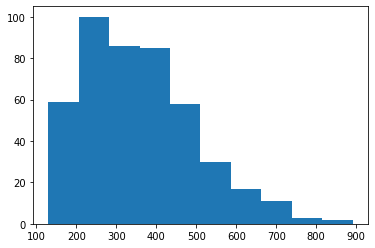

In [151]:
# percentiles
current_perc = 80
segment_widths_perc = np.array([np.percentile(k,current_perc) for k in segment_width_measurements])
plt.hist(segment_widths_perc)

In [153]:
width_threshold_perc = 800
pieces_above_width_thr = segment_widths_perc>width_threshold

pieces_above_threshold = np.where(pieces_above_width_thr)[0]# & pieces_above_size_thr)[0]

sk_large = [segment_branches[k] for k in pieces_above_threshold]
mesh_large = [divided_submeshes[k] for k in pieces_above_threshold]

nviz.plot_objects(main_mesh=tu.combine_meshes([limb_mesh_mparty,cloud_neuron["S0"].mesh]),
                  main_mesh_color="green",
    skeletons=sk_large,
                 meshes=mesh_large,
                  meshes_colors="red")

In [69]:
nviz.plot_objects(meshes=limb_object.mesh,
                 skeletons=sk_meshparty,
                 show_at_end=True)

# Try the branch searching on other limbs

In [231]:
curr_limb = 5
limb_object = cloud_neuron[curr_limb]
root = np.array(limb_object.current_touching_soma_vertices[0])

In [232]:
nviz.visualize_neuron(cloud_neuron,
                     visualize_type=["mesh","skeleton"],
                     limb_branch_dict={f"L{curr_limb}":"all"})


 Working on visualization type: mesh

 Working on visualization type: skeleton


In [233]:
m_sk = reload(m_sk)
sk_meshparty_obj,limb_mesh_mparty = m_sk.skeletonize_mesh_largest_component(limb_object.mesh,
                                                        root=np.array(limb_object.current_touching_soma_vertices[0]))
m_sk = reload(m_sk)

(segment_branches, #skeleton branches
divided_submeshes, divided_submeshes_idx, #mesh correspondence (mesh and indices)
segment_widths_median) = m_sk.skeleton_obj_to_branches(sk_meshparty_obj,
                                                      mesh = limb_mesh_mparty)


  0%|          | 0/1 [00:00<?, ?it/s]

smooth_neighborhood = 1


100%|██████████| 1/1 [00:00<00:00, 10.65it/s]

empty_indices % = 0.0
 conflict_indices % = 0.0



AFTER face_lookup_resolved_test


In [234]:
#using the width threshold
width_threshold = 450
size_threshold = 1000

segment_widths_median = np.array(segment_widths_median)
pieces_above_width_thr = segment_widths_median>width_threshold

pieces_above_threshold = np.where(pieces_above_width_thr)[0]

width_large = segment_widths_median[pieces_above_threshold]
sk_large = [segment_branches[k] for k in pieces_above_threshold]
mesh_large_idx = [divided_submeshes_idx[k] for k in pieces_above_threshold]

mesh_large_connectivity = tu.mesh_list_connectivity(meshes = mesh_large_idx,
                        main_mesh = limb_mesh_mparty,
                        print_flag = False)
"""
Pseudocode: 
1) build a networkx graph with all nodes for mesh_large_idx indexes
2) Add the edges
3) Find the connected components
4) Find sizes of connected components
5) For all those connected components that are of a large enough size, 
add the mesh branches and skeletons to the final list


"""
G = nx.Graph()
G.add_nodes_from(np.arange(len(mesh_large_idx)))
G.add_edges_from(mesh_large_connectivity)
conn_comp = list(nx.connected_components(G))

sk_large_size_filt = []
mesh_large_idx_size_filt = []
width_large_size_filt = []

for cc in conn_comp:
    total_cc_size = np.sum([len(mesh_large_idx[k]) for k in cc])
    if total_cc_size>size_threshold:
        print(f"cc ({cc}) passed the size threshold because size was {total_cc_size}")
        for indiv_cc in cc:
            sk_large_size_filt.append(sk_large[indiv_cc])
            mesh_large_idx_size_filt.append(mesh_large_idx[indiv_cc])
            width_large_size_filt.append(width_large[indiv_cc])

nviz.plot_objects(main_mesh=tu.combine_meshes([limb_mesh_mparty,cloud_neuron["S0"].mesh]),
                  main_mesh_color="green",
    skeletons=sk_large_size_filt,
     meshes=[limb_mesh_mparty.submesh([k],append=True) for k in mesh_large_idx_size_filt],
      meshes_colors="red")

cc ({0}) passed the size threshold because size was 35808


In [213]:
len(mesh_large_idx_size_filt)

11

In [196]:

# Function that will group together touching meshes by face_idx


In [208]:
tu = reload(tu)


[(1, 0), (2, 1), (4, 3), (16, 15), (17, 13)]

In [192]:
limb_submeshes[0].show()

In [ ]:
nviz.plot_objects(main_mesh=tu.combine_meshes([limb_mesh_mparty,cloud_neuron["S0"].mesh]),
                  main_mesh_color="green",
    skeletons=sk_large,
                 meshes=mesh_large,
                  meshes_colors="red")